In [1]:
import re

########################
# Handlers de columnas #
########################

# Sort from lower to higher so that the lowest is 0 and the highest is n
def sortColumnByPriceAverage(X, columnName):
  companies = {}

  for product in X[columnName]:
    companies[product] = (0, 0)

  for i, company in enumerate(X[columnName]):
    price = X["Price"][i]
    val, n = companies[company]
    val += price

    companies[company] = (val, n+1)

  _companies = [ (company, companies[company][0]) for company in companies ]
  sortedCompanies = list(map(lambda t: t[0], sorted(_companies, key=lambda t: t[1])))

  return sortedCompanies

##########
# Screen #
##########

def handle_screen_pixels(row):
  resolution = re.findall("\d+x\d+", row["ScreenResolution"])[0]
  w, h = [ int(_) for _ in resolution.split("x") ] # Ancho y alto

  return w*h

def handle_is_screen_ips(row):
  return "IPS" in row["ScreenResolution"]

def handle_has_touchscreen(row):
  res = row["ScreenResolution"]
  return "Touchscreen" in res or "touchscreen" in res

#######
# CPU #
#######

def handle_cpu_speed(row):
  return float( row["Cpu"].split()[-1][:-3] )

def handle_cpu_brand(row):
  #return row["Cpu"].split()[1]
  amd_regex = "AMD[^\d]+"
  intel_regex = "Intel[^\d]+(?:\d[\s-])?"
  samsung_regex = "Samsung[\w\s]+"

  res = re.findall(amd_regex+"|"+intel_regex+"|"+samsung_regex, row["Cpu"])

  if res:
    res = res[0]
    if res[-1] == "-": res = res[:-1] # Quitar - al final
    
    return res.strip()
  else:
    print("CPU not found")
    return ""


#######
# GPU #
#######

def handle_gpu_model(row):
  regex_amd = "AMD (?:FirePro|R\d|Radeon (?:R\d?\w?)?)"
  regex_arm = "ARM Mali"
  regex_intel = "Intel [^\d]*"
  regex_nvidia = "Nvidia (?:(?:GeForce)?\s?G?T?X?|Quadro)+"

  res = re.findall(regex_amd+"|"+regex_arm+"|"+regex_intel+"|"+regex_nvidia, row["Gpu"])

  if res:
    return res[0].strip()
  else:
    print("Model not found", row["Gpu"], res)
    return ""

def handle_cpu_antiguedad(row):
  model = handle_gpu_model(row)
  model_number = row["Cpu"].replace(model, "").strip() # El numero es lo que se queda al quitarle el modelo

  n = re.findall("(\d{4})", model_number) # Obtener el numero

  return n

def handle_gpu_model_number(row):
  model = handle_gpu_model(row)
  model_number = row["Gpu"].replace(model, "").strip() # El numero es lo que se queda al quitarle el modelo

  n = re.findall("\d+", model_number) # Obtener el numero

  if not n:
    return 2 # No lo ha encontrado o no lo tiene. Si pongo 0 aumenta. Puede ser overfitting.
  else:
    return int(n[0].strip())

def handle_gpu_model_gama(row):
  model = handle_gpu_model(row)
  model_number = row["Gpu"].replace(model, "").strip() # El numero es lo que se queda al quitarle el modelo

  n = re.findall("\d+", model_number) # Obtener el numero

  if not n:
    return "Indeterminada" # No lo ha encontrado o no lo tiene. Si pongo 0 aumenta. Puede ser overfitting.
  else:
    #"Muy Alta" if int(n[0].strip()) > 1000 else 
    return "Alta" if int(n[0].strip()) > 700 else "Media" if int(n[0].strip()) > 500 else "Baja"

###########
# Storage #
###########

def parse_memory(mem):
   regex_memoria = "(\d*\.?\d+)(\w+) (SSD|HDD|Flash Storage|Hybrid)" # Regex para identificar la memoria
   return [ x for x in re.findall(regex_memoria, mem) ] # Lista con tuplas de todos los discos encontrados

def handle_storage_capacity(row):
  productos = parse_memory(row["Memory"])
  capacity = sum([
      float(producto[0]) * (1000 if producto[1] == "TB" else 1) for producto in productos
  ])

  return capacity

def handle_has_ssd(row):
  productos = parse_memory(row["Memory"])
  return any([ producto[2] == "SSD" for producto in productos ])

######
# OS #
######

def handle_is_os_free(row):
  return row["OpSys"] not in ["No OS", "Linux"] # Cambiar


In [ ]:
#@title  { form-width: "400px" }
import pandas as pd
import numpy as np
import seaborn as sns
import re
import random
from copy import deepcopy
import statistics as stat
import sklearn.compose
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet
#from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler,PolynomialFeatures,OneHotEncoder,MinMaxScaler,OrdinalEncoder,RobustScaler
from sklearn.model_selection import GridSearchCV

# Random forest rands:
# 16 -> 185
# 29487 -> 185.52
# 37057 -> 185.61 / 7
# 37919 -> 185.23 / 6.74

#
# Ideas: Cpu novelty
#


# Ignorar errores de divergencias cuando alpha=0
import warnings
warnings.filterwarnings('ignore')

##########
# Modelo #
##########
class Model:
  def __init__(self, alpha, ratio):
    self.TRAIN_URL = "https://filebin.net/3sw6utbuul0sh225/train.csv"
    self.TEST_URL  = "https://filebin.net/3sw6utbuul0sh225/test.csv"

    self.alpha = alpha
    self.ratio = ratio

    self.X = None
    self.Y = None
    self.X_T = None
    self.Y_T = None

    self.trained_model = None
    self.prediction = None
    self.csv = None

    self.pipe = None # El conjunto de regresores que se aplican

    self.X_original = None
    self.X_final = None

  ###########
  # Dataset #
  ###########
  def load_datasets(self):
    self.X = pd.read_csv(self.TRAIN_URL, sep=",")
    self.Y = pd.read_csv(self.TEST_URL,  sep=",")
    
    # Mantener una copia para echarle un vistazo
    self.X_original = self.X.copy(deep=True)
    self.Y_original = self.X.copy(deep=True)
  
  ##############################
  # Transformacion de columnas #
  ##############################
  # Aplica la funcion f a todos los elementos de una columna
  def map_column(self, columna, f):
    self.X[columna] = [ f(val) for val in self.X[columna] ]
    self.Y[columna] = [ f(val) for val in self.Y[columna] ]
  
  def add_column(self, columna, f):
    self.X[columna] = self.X.apply(lambda row: f(row), axis=1)
    self.Y[columna] = self.Y.apply(lambda row: f(row), axis=1)

  # Modifica los valores de cada columna. Se pueden comentar y no pasa nada.
  def modify_columns(self):
    # Listas auxiliares ordenadas por peso
    sortedCompanies = sortColumnByPriceAverage(self.X, "Company")
    sortedTypeNames = sortColumnByPriceAverage(self.X, "TypeName")
    #sortedOS = ["No OS", "Linux", "Android", "Chrome OS", "Windows 10 S", "Windows 7", "Windows 10", "macOS", "Mac OS X"]

    # New colums
    self.add_column("StorageCapacity", handle_storage_capacity)
    self.add_column("HasSSD", handle_has_ssd)
    self.add_column("ScreenPixels", handle_screen_pixels)
    self.add_column("IsScreenIPS", handle_is_screen_ips)
    self.add_column("HasTouchscreen", handle_has_touchscreen)
    self.add_column("IsOSFree", handle_is_os_free)
    self.add_column("CPUBrand", handle_cpu_brand)
    self.add_column("CPUSpeed", handle_cpu_speed)
    #self.add_column("CPUModelAntiguedad", handle_cpu_antiguedad)
    self.add_column("GPUModel", handle_gpu_model)
    self.add_column("GPUModelNumber", handle_gpu_model_number) 
    self.add_column("GPUModelGama", handle_gpu_model_gama)                      # Gama

    self.map_column("Ram",              lambda val: int(val[:-2]))
    self.map_column("Weight",           lambda val: float(val[:-2]))            # Baja un poooooooooooco el error
    self.map_column("Company",          lambda val: sortedCompanies.index(val))
    self.map_column("TypeName",         lambda val: sortedTypeNames.index(val))

    # Another X for consulting and visualization
    self.X_final = self.X.copy(deep=True)\
      .drop(["Product", "OpSys", "Company", "ScreenResolution", "Cpu", "Gpu", "Memory"], axis=1)

  def transform_datasets(self):
    categoriesCPUBrand = ['AMD A', 'AMD E-Series', 'AMD E-Series E', 'Intel Atom X5', 'Intel Atom x5',
                          'Intel Atom Z', 'Intel Celeron Dual Core', 'Intel Celeron Dual Core N',
                          'Intel Celeron Quad Core N', 'Intel Core M', 'Intel Core M M3', 'Intel Core M m3',
                          'Samsung Cortex A72', 'Intel Core M M7', 'Intel Pentium Dual Core', 'Intel Pentium Dual Core N',
                          'Intel Pentium Quad Core N', 'Intel Core M m7', 'Intel Core i3', 'Intel Core i5', 'AMD FX',
                          'AMD Ryzen', 'Intel Core i7', 'Intel Xeon E3' ]

    transformersX = [
        ("LaptopId",          "drop",               [0]),
        ("Company",           "passthrough",        [1]),
        ("Product",           "drop",               [2]),
        ("TypeName",          StandardScaler(),        [3]),
        ("Inches",            StandardScaler(),        [4]),
        ("ScreenResolution",  "drop",               [5]),
        ("Cpu",               "drop",               [6]),
        ("Ram",               StandardScaler(),     [7]),
        ("Memory",            "drop",               [8]),
        ("Gpu",               "drop",               [9]),
        ("OpSys",             "drop",               [10]),
        ("Weight",            StandardScaler(),        [11]),
        ("Price",             "drop",               [12]),

        # New Columns
        ("StorageCapacity",       StandardScaler(),        [13]),
        ("HasSSD",                OneHotEncoder(),      [14]),
        ("ScreenPixels",          StandardScaler(),     [15]),
        ("IsScreenIPS",           OneHotEncoder(),      [16]),
        ("HasTouchscreen",        OneHotEncoder(),      [17]),
        ("IsOSFree",              "passthrough",        [18]),
        ("CPUBrand",              OrdinalEncoder(categories=[categoriesCPUBrand]),     [19]),
        ("CPUSpeed",              StandardScaler(),     [20]),
        #("CPUModelAntiguedad",    OrdinalEncoder(),     [21]),
        ("GPUModel",              OrdinalEncoder(),     [21]),
        ("GPUModelNumber",        OrdinalEncoder(),     [22]),
        ("GPUModelGama",          OrdinalEncoder(),     [23])
    ]

    transformersY = deepcopy(transformersX)

    # Normbrar el orden de columnas de 0 a n-1
    transformersY.pop(12) # Eliminar precio
    for i, t in enumerate(transformersY): # Renumerar los indices de las columnas
      transformersY[i][2].pop()
      transformersY[i][2].append(i)

    self.X_T = sklearn.compose.ColumnTransformer(transformers=transformersX).fit_transform(self.X)
    self.Y_T = sklearn.compose.ColumnTransformer(transformers=transformersY).fit_transform(self.Y)

    # StandardScaler. No cambia mucho.
    self.X_T = sklearn.preprocessing.StandardScaler().fit_transform(self.X_T)
    self.Y_T = sklearn.preprocessing.StandardScaler().fit_transform(self.Y_T)
  
  ##########################
  # Regresion y prediccion #
  ##########################
  def set_pipe(self):
    max_features  = 8       #@param {type:"raw"}
    max_depth     = 40      #@param {type:"raw"}
    random_state  = 121212   #@param {type:"raw"}

    pipe = Pipeline([#('poly', PolynomialFeatures(degree=1)),
                     #('standardscaler', StandardScaler()),
                     #('elasticnet',  ElasticNet(alpha=self.alpha, l1_ratio=self.ratio)),
                     #('sgd', SGDRegressor(max_iter=100, random_state=42)),
                     #('extratrees', ExtraTreesRegressor(n_estimators=40)),
                     ('randomforest', RandomForestRegressor(
                         criterion="mae",
                         max_features=max_features,
                         max_depth=max_depth,
                         random_state=random_state))
    ])

    self.pipe = pipe

  def apply_regression(self):
    self.trained_model = self.pipe.fit(self.X_T, self.X["Price"])

  def predict(self):
    self.prediction = self.trained_model.predict(self.Y_T)

  #######
  # CSV #
  #######
  def to_csv(self):
    self.solucion = pd.DataFrame(data = {
        "LaptopId" : self.Y["LaptopId"],
        "Price"    : self.prediction
    })
  
  def save_csv(self, name):
    self.solucion.to_csv(name, index=False)

  #################
  # Ejecutar todo #
  #################
  def run(self):
    # Obtener y parsear datasets
    self.load_datasets()
    self.modify_columns()
    self.transform_datasets()

    # Aplicar regresion y hacer una prediccion
    self.set_pipe()
    self.apply_regression()
    self.predict()

    # Convertir a csv
    self.to_csv()
    self.save_csv("solucion.csv")
  
  def print_avgs(self):
    train_avg = sum(self.X["Price"]) / len(self.X["Price"])
    pred_avg  = sum(self.prediction) / len(self.prediction)

    print("Medias\n" + "-" * 100)
    print("Avg training set :", train_avg)
    print("Avg prediction   :", pred_avg)
    print("Diff             :", abs(train_avg - pred_avg), "\n")
    #print("\nScore:", self.trained_model.score()) TODO: FIX

  def print_stats(self):
    print("Intercept (precio basico):", self.prediction.intercept_)
    print("Coeficientes:", self.prediction.coef_)
    print("Correlaciones:", pd.DataFrame(data=np.expand_dims(self.prediction.coef_, axis=0), columns=self.model.X.feature_names))


############################
# Clase para probar el MAE #
############################
class ModelTest(Model):
  def __init__(self, alpha, ratio, partition_n):
    # Inicializar padre. Tiene que ser la primera llamada dentro del __init__
    super().__init__(alpha, ratio) 

    self.PARTITION_N = partition_n # Numero de particiones que se van a probar
    self.maes = None               # Array con los maes de cada intento

  def get_maes(self):
    # Prueba n particiones para training y validacion y devuelve el error obtenido en cada intento
    self.maes = cross_val_score(self.pipe, self.X_T, self.X["Price"],
                                cv=self.PARTITION_N, scoring="neg_mean_absolute_error")
    
  def grid_search(self):
    clf = GridSearchCV(RandomForestRegressor(),#random_state=37925),
      {"random_state": [random.randint(0, 1000000000) for x in range(100)]}
    )
    clf.fit(self.X_T, self.X["Price"])
    display(clf.cv_results_)

  def run(self):
    self.load_datasets()
    self.modify_columns()
    self.transform_datasets()
    self.set_pipe()
    self.get_maes()

  def print_MAE(self):
    print("MAEs    :", self.maes)
    print("MAE avg :", stat.mean(self.maes))
    print("MAE std :", stat.variance(self.maes)**(1/2))

def main():
  es_prueba = True   #@param {type:"boolean"}
  alpha = 0       
  ratio = 0         
  partition_n = 5    #@param {type:"slider", min:0, max:10,  step:1}

  if es_prueba:
    # Ejecutar para hacer pruebas
    model_test = ModelTest(alpha=alpha, ratio=ratio, partition_n=partition_n)
    model_test.run()
    model_test.print_MAE()

    return model_test

  else:
    # Ejecutar para guardar el resultado
    model = Model(alpha=alpha, ratio=ratio)
  
    model.run()
    model.print_avgs()
    #model.print_stats()

    return model

model = main()


MAEs    : [-165.58861093 -156.33749071 -177.35471484 -185.90552033 -176.5359706 ]
MAE avg : -172.344461481715
MAE std : 11.493893318132088


In [ ]:
model.X_final

,LaptopId,TypeName,Inches,Ram,Weight,Price,StorageCapacity,HasSSD,ScreenPixels,IsScreenIPS,HasTouchscreen,IsOSFree,CPUBrand,CPUSpeed,GPUModel,GPUModelNumber,GPUModelGama
0,981,5,13.3,4,1.20,1195.00,128.0,True,2073600,False,False,True,Intel Core i5,2.3,Intel HD Graphics,520,Media
1,996,3,13.3,8,1.11,1349.00,256.0,True,2073600,True,True,True,Intel Core i7,2.7,Intel HD Graphics,620,Media
2,77,5,15.6,8,2.02,855.00,1128.0,True,2073600,False,False,True,Intel Core i7,1.8,Intel UHD Graphics,620,Media
3,103,3,13.3,8,1.38,1119.00,256.0,True,2073600,True,False,True,Intel Core i7,2.7,Nvidia GeForce,150,Baja
4,946,3,12.5,8,1.36,1472.20,256.0,True,2073600,False,True,True,Intel Core i5,2.5,Intel HD Graphics,2,Indeterminada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,994,2,13.3,8,1.68,889.00,256.0,True,2073600,False,True,True,Intel Core i5,2.5,Intel HD Graphics,620,Media
908,615,4,17.3,8,3.00,1168.00,1128.0,True,2073600,False,False,True,Intel Core i7,2.8,Nvidia GeForce GTX,1050,Alta
909,1063,5,15.6,16,2.32,989.99,2000.0,False,2073600,False,False,True,Intel Core i7,2.7,AMD Radeon R7,445,Baja
910,96,5,15.6,8,2.20,599.90,1000.0,False,2073600,False,False,False,Intel Core i7,2.7,AMD Radeon R5,430,Baja


In [8]:
# 23 - MAE avg : -174.9321064598971
# 86 - MAE avg : -174.91772986151787
# 79 - MAE avg : -174.3536607499564

#model.X_final
#set(model.X_final["GPUModel"])
set(model.X_original["Gpu"])

NameError: ignored

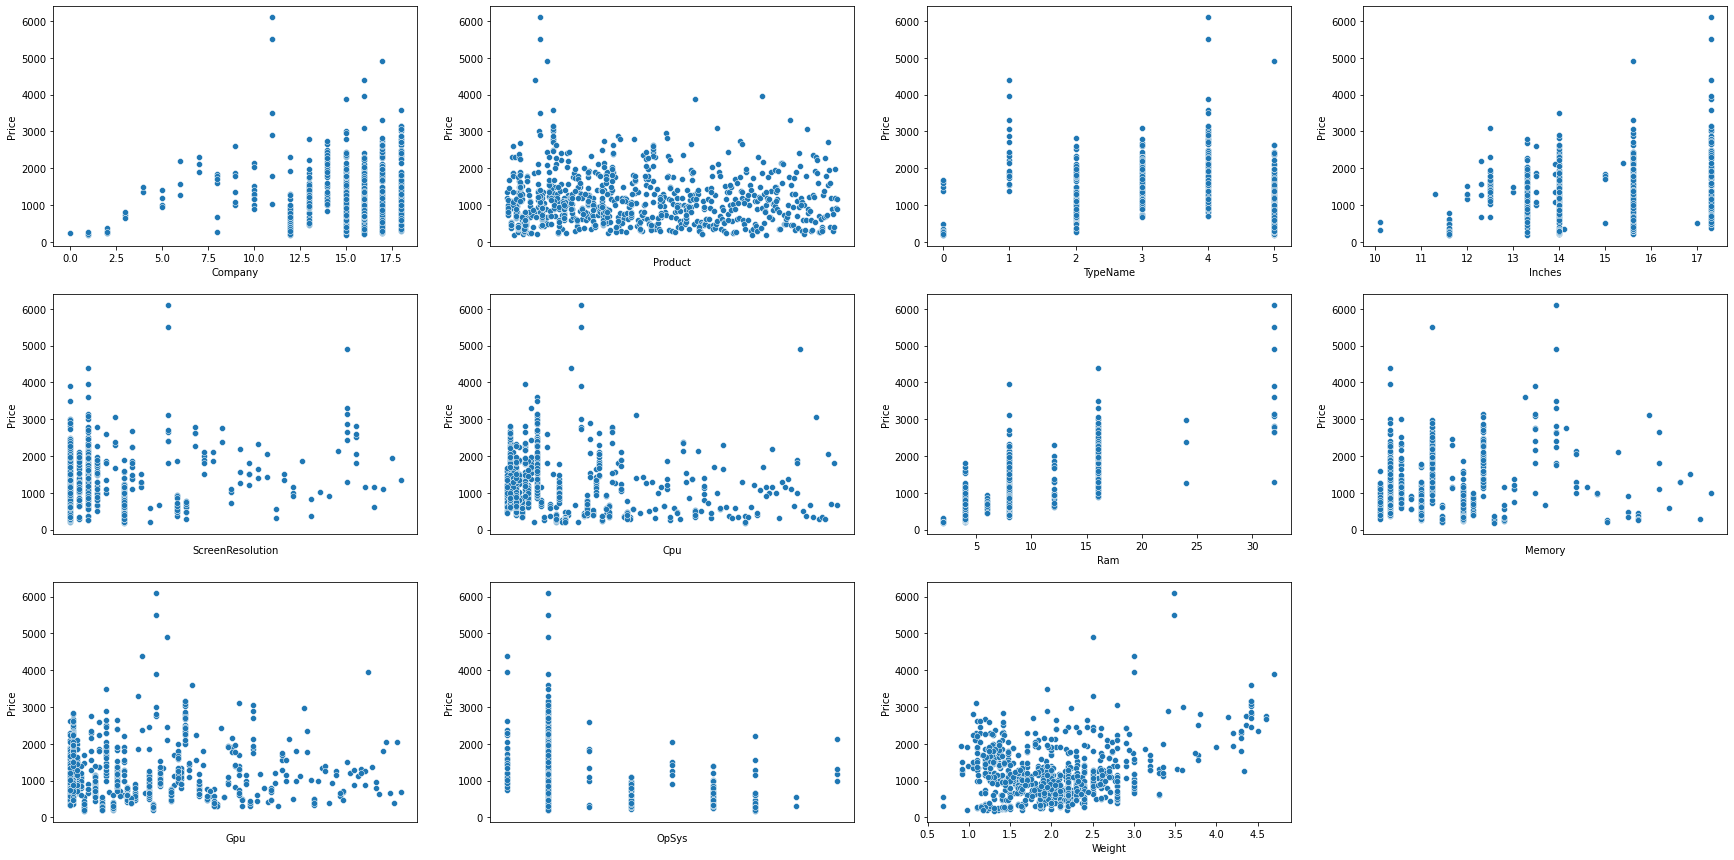

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Relplot
# Scatterplot
# Density plot
# Characteristic line plot

class Draw:
  def __init__(self, model):
    self.model = model
    self.labels = ["Company", "Product", "TypeName", "Inches", "ScreenResolution", "Cpu", "Ram", "Memory", "Gpu", "OpSys", "Weight"]

  def get_grid(self, cols, rows, h, w):
      return plt.subplots(rows, cols, figsize=(w, h))

  def histogram(self, labels):
    fig0, axs0 = plt.subplots(ncols=4)
    fig0.set_figwidth(30)
    fig0.set_figheight(5)

    for i, label in enumerate(labels):
      aux = sns.histplot(self.model.X[label], ax=axs0[i])

      aux.set_xticklabels(aux.get_xticklabels(), rotation = 80, horizontalalignment = 'right')

    #plt.show()

  def countplot(self, labels):
    fig0, axs0 = plt.subplots(ncols=4)
    fig0.set_figwidth(30)
    fig0.set_figheight(5)

    for i, label in enumerate(labels):
      aux = sns.countplot(self.model.X[label], ax=axs0[i])

      #aux0.set_xticklabels(aux0.get_xticklabels(), rotation = 85, horizontalalignment = 'right')

      aux.set(xticklabels=label)
      aux.set(xlabel=None)

  def kde(self, labels):
    # El numero de caracteristicas que tienen tipo numerico, para decidir las dimensiones
    n_of_numerical_features = len([ True for f in self.model.X if type(self.model.X[f][0]) != str ])
    
    fig, axs = self.get_grid(rows=n_of_numerical_features//4, cols=4, h=10, w=25)
    fig.delaxes(axs[1][2]) # Elimnar plots vacios
    fig.delaxes(axs[1][3])
    
    i = 0
    for label in labels:
      if type(self.model.X[label][0]) != str:
        sns.kdeplot(self.model.X[label], ax=axs[i//4, i%4])
        i += 1
  
  def relplot(self, labels, hue=None):
    fig, axs = self.get_grid(rows=3, cols=4, h=15, w=30)
    fig.delaxes(axs[2][3]) # Elimnar plots vacios

    for i, label in enumerate(labels):
      s = sns.scatterplot(data=self.model.X, x=label, y="Price", ax=axs[i//4, i%4], hue=hue)

      # Si es una feature con strings, quitar los ticks porque si no no se ve nada
      if type(self.model.X[label][0]) == str:
        s.set(xticklabels=[])  
        s.tick_params(bottom=False)

  def run(self):
    #self.countplot(["ScreenResolution", "Cpu", "Gpu", "Weight"])
    #self.histogram(["ScreenResolution", "Cpu", "Gpu", "Weight"])
    #self.kde(self.labels)
    self.relplot(self.labels)

    #plt.show()

  
draw = Draw(model)
draw.run()